# Paper figure 5
### Derived from Notebook 21, for testing the SETP-identification algorithms

In [2]:
import sys
sys.path.append("..") #import folder which is one level higher

In [3]:
from classes import *

import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import random

from tqdm.notebook import trange, tqdm
from pathlib import Path

from matplotlib import patches
from matplotlib.collections import PatchCollection

In [5]:
#Load the experiments
#input_path = "../temp/experiments/experiment_selection_2021_1_19.p"
input_path = "../temp/experiments/experiment_selection_2021_2_19.p"
assert Path(input_path).exists()
experiments = pickle.load( open( input_path, "rb" ) )
print(len(experiments))

1400


In [6]:
#SET THE PARAMETERS TO DO THE ANALYSIS
window = 4 #The size of the rolling window
margin = 2 # The margin around the TP

#Criteria
c1 = 0.15 #fraction of change relative to house price at t0
c2 = 1.5e9 #variance threshold
c3 = 10 #percentage change between states

In [7]:
with tqdm(total=len(experiments)) as pbar:
    for experiment in experiments:
        experiment.create_Metrics() #TODO: GIVE CONTROL OVER THE METRICS TO BE CREATED
        for M in experiment.allMetrics:
            M.create_statistics(window=window) #Create summary statistics for the metric(t)
            M.find_SETP_candidates(c1=c1,c2=c2,c3=c3,margin=margin)
            M.select_SETPs(sign=-1,add_stable_before=True) #Also consider states which are only stable before as policy relevant
        pbar.update(1)

### Visualisations of individual experiments

In [8]:
def add_suptitle(fig,exp,M):
    """Add some information about the experiment as title to the figure
    
    Arguments:
        fig (Matplotlib Figure) : Figure created with M.plot_SETPs
        exp : experiment object from which to draw the metadata
        metric : the metric from which to draw the metadata
        
    Returns:
        fig (Matplotlib Figure) : the input figure with a suptitle
    
    """
    
    #Make the data of the experiment more readable before sending it to the string
    housing_market = M.name.split('_')[-1]
    if housing_market == 'subj':  housing_market = 'Boundedly rational'
    else: housing_market = 'Rational'
    
    area_name = M.name.split('_')[1]
    if area_name == 'A': area_name = 'A (Heijplaat, outer-dike)'
    else: area_name = 'B (City Centre, inner-dike)'
    
    #Create the title string
    suptitle_string = (\
    '''Sea level rise scenario: {} ||| Storm surge series: {} ||| Mayor: {} ||| Impl. time: {}
    {} housing market ||| Area {}'''.format(
                                   exp.SurgeLevel.corresponding_SLR_Scenario.name.split('_')[-1],
                                   exp.SurgeLevel.corresponding_SurgeHeight.name.split('_')[-1],        
                                   exp.Mayor.get_name(),
                                   str(exp.ImplementationTime),
                                   housing_market,
                                   area_name))
    fig.suptitle(suptitle_string)
    
    file_string = exp.SurgeLevel.corresponding_SLR_Scenario.name.split('_')[-1] + '_' +\
                  exp.SurgeLevel.corresponding_SurgeHeight.name.split('_')[-1] + '_' + \
                  exp.Mayor.get_name() + '_' + str(exp.ImplementationTime) + \
                  M.name.split('_')[-1] + '_' + M.name.split('_')[1]
    return fig,file_string
    

In [9]:
#CREATE SUBFOLDER IN VISUALISATION WITH CURRENT DATE + metrics
today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)
if not Path(date).exists(): Path(date).mkdir()
target = Path(date,'SETP_identification')
if not target.exists(): target.mkdir()
else: print("Target folder {} already exists".format(target))

## Show all four metrics for an interesting experiment

In [10]:
#Select four interesting experiments
nr1 = sel_exp(experiments,SLR_scenarios='01',SurgeHeights='five_hundred_0',Mayors='R. Active',ITs=(4,6))
nr1 # Area_A, Housing Market

nr2 = sel_exp(experiments,SLR_scenarios='01',SurgeHeights='five_hundred_0',Mayors='H. Economicus',ITs=(7,10))
# Area_A, Rat HM

#1 of 2 gaat wel geleidelijk naar 0, maar nergens zo snel dat het een tipping point mag heten (je kunt wel stable states onderscheiden)

nr3 = sel_exp(experiments,SLR_scenarios='01',SurgeHeights='five_hundred_312',Mayors='Sentiment',ITs=(11,16))
nr3 #A; BR => Deze gaat in twee duidelijke stappen naar 0, ziet er mooi uit!

nr4 = sel_exp(experiments,SLR_scenarios='02',SurgeHeights='five_hundred_0',Mayors='R. Active',ITs=(4,6))
nr4 #A, BR => als nr 3, maar dan wat chaotischer, met ook nog een geval waar niks gebeurd en een duplicate

nr5 = sel_exp(experiments,SLR_scenarios='02',SurgeHeights='five_hundred_1',Mayors='H. Economicus',ITs=(7,10))
nr5 #Interressant omdat er vier gevallen van same states zijn; nadeel: nogal onduidelijk

nr6 = sel_exp(experiments,SLR_scenarios='02',SurgeHeights='five_hundred_1',Mayors='Lawkeeper',ITs=(7,10))
nr6 #A, BR; Tipping point, not substantial difference; only before; only after

nr7 = sel_exp(experiments,SLR_scenarios='02',SurgeHeights='five_hundred_272',Mayors='Sentiment',ITs=(4,6))
nr7 #Dit is een voorbeeld van nogal chaotisch gedrag, waar het een enkele keer wel mis zou kunnen gaan

nr8 = sel_exp(experiments,SLR_scenarios='03',SurgeHeights='five_hundred_0',Mayors='Sentiment',ITs=(9,13))
nr8 #B, BR #voorbeeld van 1 fluctuatie en één kortdurend tipping points

nr9 = sel_exp(experiments,SLR_scenarios='03',SurgeHeights='five_hundred_1',Mayors='Sentiment',ITs=(4,6))
nr9 #B, BR Twee keer net geen tipping point (wel rapid change, maar bounced terug naar ori state)

nr10 = sel_exp(experiments,SLR_scenarios='03',SurgeHeights='five_hundred_3',Mayors='Lawkeeper',ITs=(11,8))
nr10 #A, BR Bounced twee keer terug naar de originele staat, om dan te eindigen met een echt SETP

nr11 = sel_exp(experiments,SLR_scenarios='03',SurgeHeights='five_hundred_3',Mayors='Economicus',ITs=(14,20))
nr11 #B, R Elke keer net niet snel genoeg om SETP te zijn.

nr12 = sel_exp(experiments,SLR_scenarios='03',SurgeHeights='five_hundred_3',Mayors='Lawkeeper',ITs=(9,13))
nr12 #A, BR same state; stable before; stable after (maar wel dubieus)

nr13 = sel_exp(experiments,SLR_scenarios='03',SurgeHeights='five_hundred_3',Mayors='R. Active',ITs=(14,20))
nr13 #B, BR stable before, than period of strong instability (reason why we also included 'Only stable before as policy relevant')

nr14 =  sel_exp(experiments,SLR_scenarios='04',SurgeHeights='five_hundred_1',Mayors='R. Active',ITs=(14,20))
nr14 #BR, Area B; hier had hij misschien toch een TP moeten laten zien? Verder een heel mooi voorbeeld van only before

nr15 =  sel_exp(experiments,SLR_scenarios='04',SurgeHeights='five_hundred_124',Mayors='R. Active',ITs=(9,13))
nr15 #BR, Area B; hier had hij misschien toch een TP moeten laten zien? Verder een heel mooi voorbeeld van only before

#Misschien goed om nog een keer te bespreken:
nr100 = sel_exp(experiments,SLR_scenarios='02',SurgeHeights='five_hundred_1',Mayors='H. Economicus',ITs=(9,13))
nr100 #Dit is een voorbeeld van nogal chaotisch gedrag, waar het een enkele keer wel mis zou kunnen gaan

nr101 = sel_exp(experiments,SLR_scenarios='02',SurgeHeights='five_hundred_272',Mayors='Lawkeeper',ITs=(14,20))
nr101 #Het is de vraag of het eerste TP hier goed geinterpreteerd wordt; misschien moet het criterium voor variance iets strenger?

nr102 = sel_exp(experiments,SLR_scenarios='03',SurgeHeights='five_hundred_2',Mayors='R. Active',ITs=(7,10))
nr102 #B, BR #Voorbeeld van een mess, illustratie waarom ik nog niet blij ben met hoe het werkt

nr103 = sel_exp(experiments,SLR_scenarios='04',SurgeHeights='five_hundred_1',Mayors='R. Active',ITs=(7,10))
nr103 #B, BR #Hier lijkt het model toch een stukje te missen: reden om de variantie iets strenger af te stellen? 
 #Waar wordt die state categorisatie precies op gebaseerd?

#voorbeelden die ik nu heb:
#net wel, en net geen tipping points
#Duidelijk een aantal tipping points
#Wel fluctuaties, maar geen echt tipping point (nr 5)

#Wat wil je dan nog?
#Iets als #5, maar dan nog duidelijker dat er nergens een echt ipping point is

#Een gevalletje, wel stable before, maar niet after.


[Rotty_Scenario_04__five_hundred_1_R. Active_(7, 10) 2021/02/19, 11:19:09]

### Visualisation of selected experiments (see below for saving all experiments)
LET OP: naamgeving van de files klopt niet helemaal. Hij doet nu het experiment. 

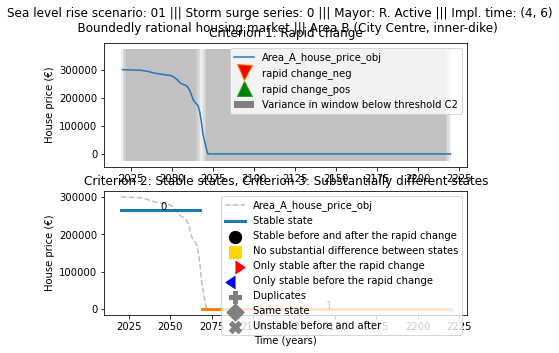

In [13]:
### Use a dummy fig to take the legend
dummy, axes = nr1[0].allMetrics[0].plot_SETPs(figsize=(6.5,5))

dummy, file_string = add_suptitle(dummy,nr1[0],M)

2021_2_19\SETP_identification\01_0_R.Active_(4,6)subj_B.png


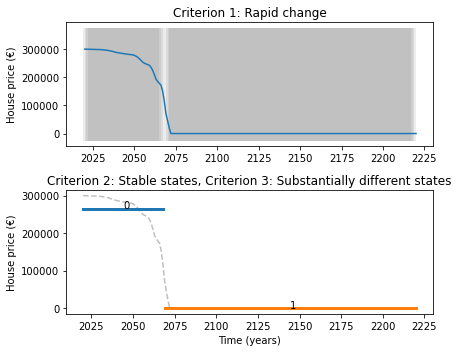

In [14]:
exp = nr1[0]

fig, axes = exp.allMetrics[0].plot_SETPs(figsize=(6.5,5))
for ax in axes:
    ax.get_legend().remove()
fig.tight_layout()

dummy, file_string = add_suptitle(dummy,exp,M) #We are only interested in the information on the filename, 
# the fig manipulation is therefore done on a dummy

filename = file_string.replace(" ", "")
to_save = target / (filename + '.png')
#fig.savefig(to_save,bbox_inches='tight',dpi=150)
print(to_save)

2021_2_19\SETP_identification\01_0_H.Economicus_(7,10)subj_B.png


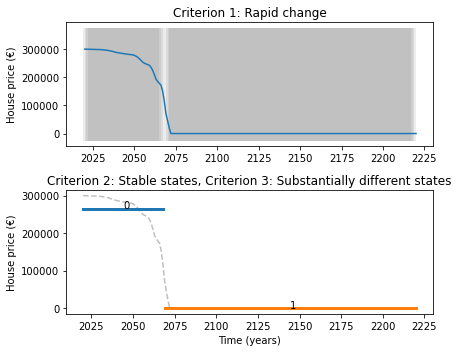

In [15]:
exp = nr2[0]

fig, axes = exp.allMetrics[0].plot_SETPs(figsize=(6.5,5))
for ax in axes:
    ax.get_legend().remove()
fig.tight_layout()

dummy, file_string = add_suptitle(dummy,exp,M) #We are only interested in the information on the filename, 
# the fig manipulation is therefore done on a dummy

filename = file_string.replace(" ", "")
to_save = target / (filename + '.png')
fig.savefig(to_save,bbox_inches='tight',dpi=150)
print(to_save)

2021_2_19\SETP_identification\01_312_Sentiment_(11,16)subj_B.png


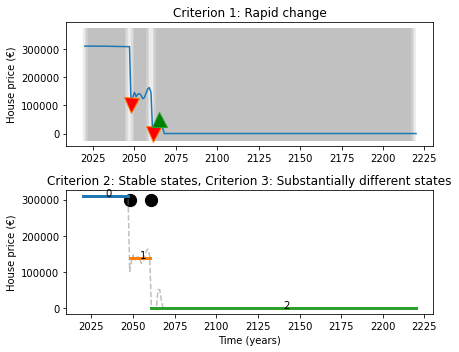

In [16]:
exp = nr3[0]

fig, axes = exp.allMetrics[1].plot_SETPs(figsize=(6.5,5))
for ax in axes:
    ax.get_legend().remove()
fig.tight_layout()

dummy, file_string = add_suptitle(dummy,exp,M) #We are only interested in the information on the filename, 
# the fig manipulation is therefore done on a dummy

filename = file_string.replace(" ", "")
to_save = target / (filename + '.png')
fig.savefig(to_save,bbox_inches='tight',dpi=150)
print(to_save)

2021_2_19\SETP_identification\03_1_Sentiment_(4,6)subj_B.png


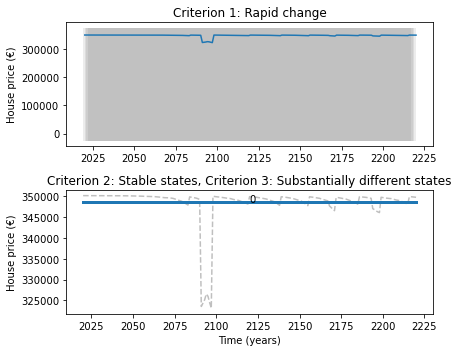

In [17]:
exp = nr9[0]

fig, axes = exp.allMetrics[3].plot_SETPs(figsize=(6.5,5))
for ax in axes:
    ax.get_legend().remove()
fig.tight_layout()

dummy, file_string = add_suptitle(dummy,exp,M) #We are only interested in the information on the filename, 
# the fig manipulation is therefore done on a dummy

filename = file_string.replace(" ", "")
to_save = target / (filename + '.png')
fig.savefig(to_save,bbox_inches='tight',dpi=150)
print(to_save)

2021_2_19\SETP_identification\03_3_R.Active_(14,20)subj_B.png


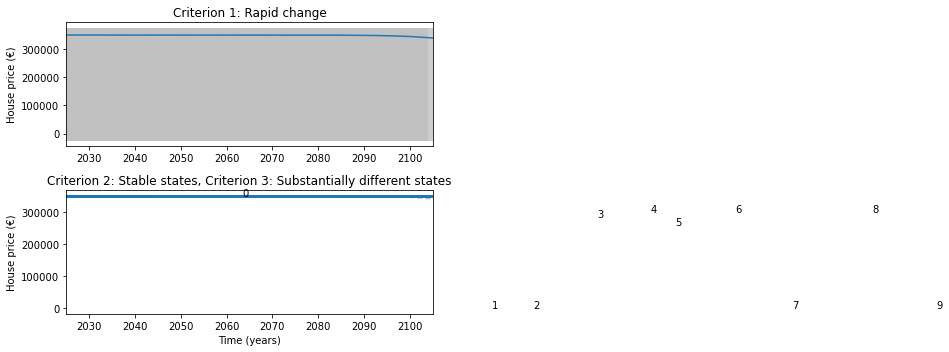

In [18]:
exp = nr13[0]

fig, axes = exp.allMetrics[3].plot_SETPs(figsize=(6.5,5))
for ax in axes:
    ax.get_legend().remove()
fig.tight_layout()

for ax in axes:
     ax.set_xlim(2025,2105)

dummy, file_string = add_suptitle(dummy,exp,M) #We are only interested in the information on the filename, 
# the fig manipulation is therefore done on a dummy

filename = file_string.replace(" ", "")
to_save = target / (filename + '.png')
fig.savefig(to_save,bbox_inches='tight',dpi=150)
print(to_save)

In [19]:
exp = nr15[0]

fig, axes = exp.allMetrics[3].plot_SETPs(window=window,figsize=(6.5,5))
for ax in axes:
    ax.get_legend().remove()
fig.tight_layout()

dummy, file_string = add_suptitle(dummy,exp,M) #We are only interested in the information on the filename, 
# the fig manipulation is therefore done on a dummy

for ax in axes:
     ax.set_xlim(2025,2225)

filename = file_string.replace(" ", "")
to_save = Path('2021_1_20/Fig_5') / (filename + '.png')
fig.savefig(to_save,bbox_inches='tight',dpi=150)
print(to_save)

TypeError: __init__() got an unexpected keyword argument 'window'

### This is how we saved all experiments

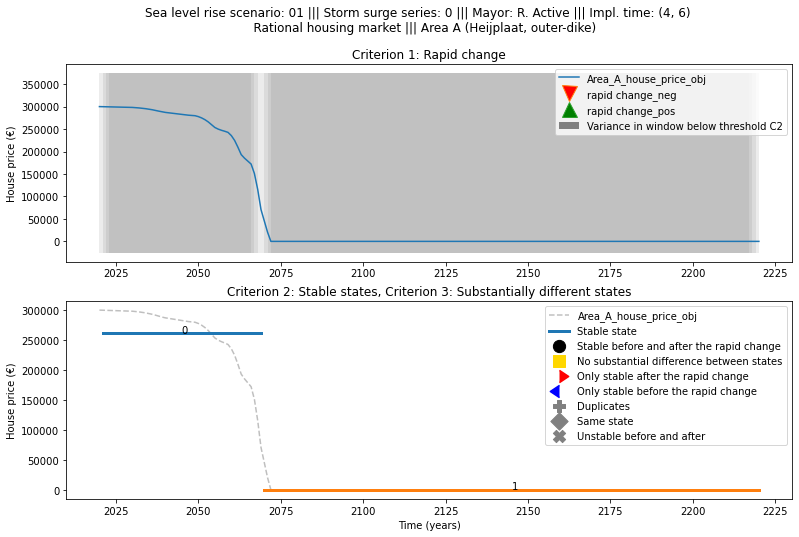

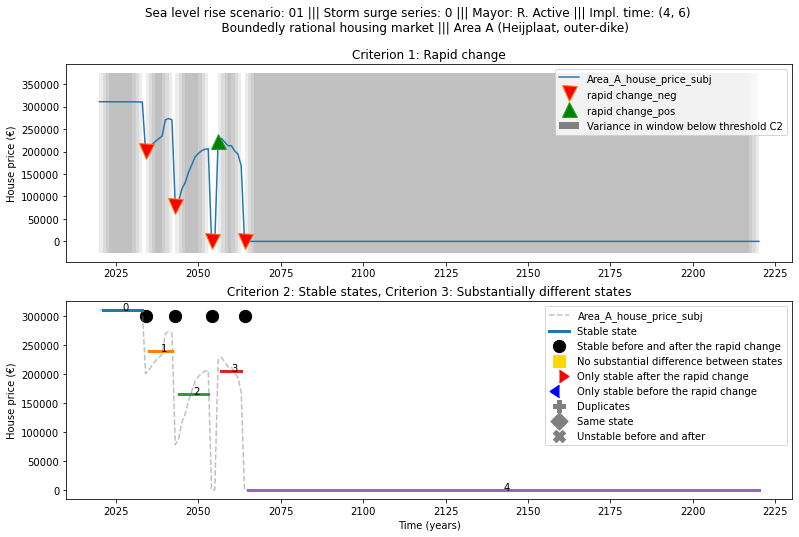

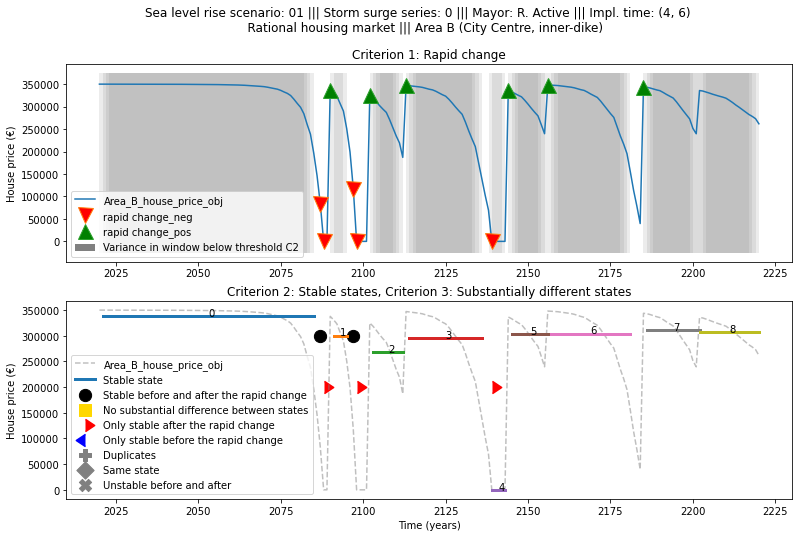

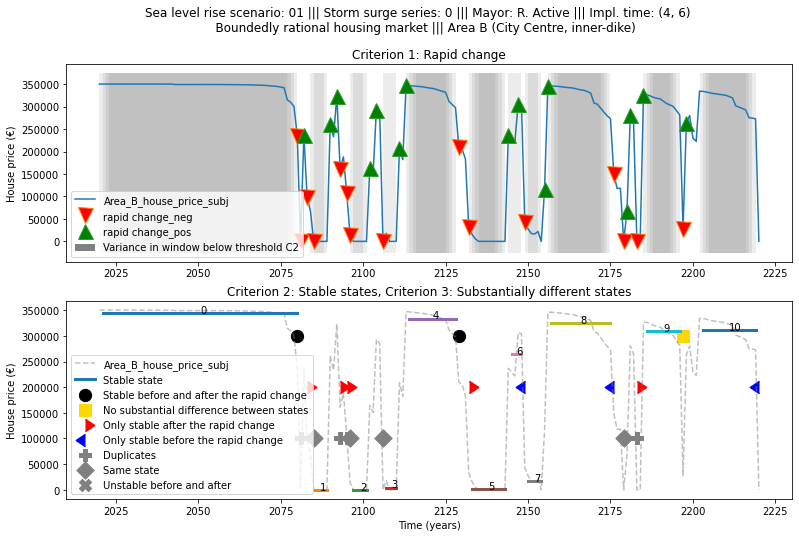

In [26]:
#Todo: show the details of the experiment in addition to the plot
exp = experiments[0]

for M in exp.allMetrics:
    
    fig, ax = M.plot_SETPs(window=window,figsize=(13,8))
    fig, file_string = add_suptitle(fig,exp,M)
    filename = file_string.replace(" ", "")
    to_save = filename + '.png'
    #fig.savefig(to_save,bbox_inches='tight',dpi=150)
    
    del fig, ax

In [60]:
import tqdm

In [25]:
with tqdm(total=len(experiments*4)) as pbar:
    for exp in experiments:
        for M in exp.allMetrics:
            fig, ax = M.plot_SETPs(window=window,figsize=(13,8))
            fig, file_string = add_suptitle(fig,exp,M)
            filename = file_string.replace(" ", "")
            to_save = Path(target, (filename + ".png"))
            if to_save.exists(): #If figure already exists, don't save the file
                plt.close(fig)
                continue
            fig.savefig(to_save,bbox_inches='tight',dpi=50)
            plt.close(fig)
            pbar.update(1)